# Import the Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from statsmodels.graphics.tsaplots import plot_acf

# Data Preprocessing

In [2]:
# Data Loading
data = pd.read_csv("D:/Downloads/Coconut_Production.csv")
data['Time'] = pd.to_datetime(data['Time'], format='%Y-%m')
data.set_index('Time', inplace=True)
print(data.head())

            Production
Time                  
2000-01-01       219.0
2000-02-01       219.0
2000-03-01       232.0
2000-04-01       207.0
2000-05-01       222.0


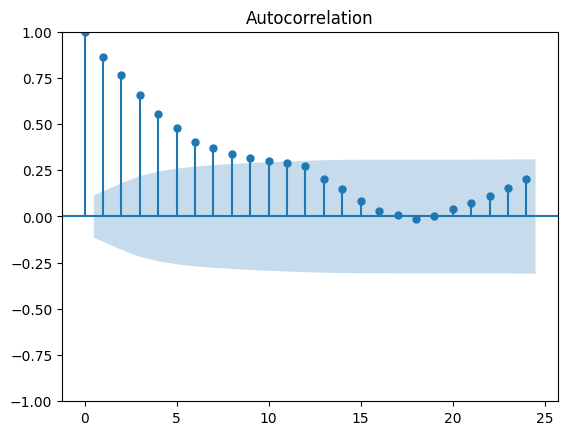

In [3]:
# Lag Features
plot_acf(data['Production'], lags=24)
plt.show()


# Feature Engineering

- **Creating Lag Features**

In [4]:
def create_lags(data, lags, diff_lags):
    for lag in lags:
        data[f'Lag_{lag}'] = data['Production'].shift(lag)

    for diff_lag in diff_lags:
        data[f'Diff_{diff_lag}'] = data['Production'].diff(diff_lag)  

    return data.dropna()

lags_to_use = [1, 2, 3, 4, 5, 6]
diff_lags_to_use = [1, 2, 3, 4, 5, 6] 

data_featured = create_lags(data.copy(), lags_to_use, diff_lags_to_use)

- **Test- Train Split**

In [5]:
# Split data into train and test sets
train_data = data_featured[:-12] 
test_data = data_featured[-12:] 

X_train = train_data.drop('Production', axis=1)
y_train = train_data['Production']
X_test = test_data.drop('Production', axis=1)
y_test = test_data['Production']


# Model Training

In [6]:
# Model Training
model = XGBRegressor(
    objective='reg:squarederror',  
    n_estimators=50,             
    max_depth=2,                   
    learning_rate=0.3,            
    reg_alpha=0.1,                 
    reg_lambda=1.0,                
    early_stopping_rounds= 10
                         
)

model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)])


[0]	validation_0-rmse:21.07152	validation_1-rmse:25.55350
[1]	validation_0-rmse:17.36527	validation_1-rmse:20.38085
[2]	validation_0-rmse:14.93589	validation_1-rmse:17.50085
[3]	validation_0-rmse:12.90661	validation_1-rmse:15.45029
[4]	validation_0-rmse:11.48279	validation_1-rmse:12.67285
[5]	validation_0-rmse:10.20162	validation_1-rmse:11.50473
[6]	validation_0-rmse:9.17678	validation_1-rmse:10.28771
[7]	validation_0-rmse:8.30766	validation_1-rmse:9.44057
[8]	validation_0-rmse:7.65279	validation_1-rmse:8.72584
[9]	validation_0-rmse:6.92094	validation_1-rmse:8.42579
[10]	validation_0-rmse:6.32184	validation_1-rmse:7.38222
[11]	validation_0-rmse:5.85960	validation_1-rmse:7.22058
[12]	validation_0-rmse:5.38235	validation_1-rmse:7.01615
[13]	validation_0-rmse:5.00671	validation_1-rmse:6.60737
[14]	validation_0-rmse:4.66538	validation_1-rmse:6.29318
[15]	validation_0-rmse:4.34777	validation_1-rmse:6.15802
[16]	validation_0-rmse:4.11131	validation_1-rmse:6.61438
[17]	validation_0-rmse:3.877

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

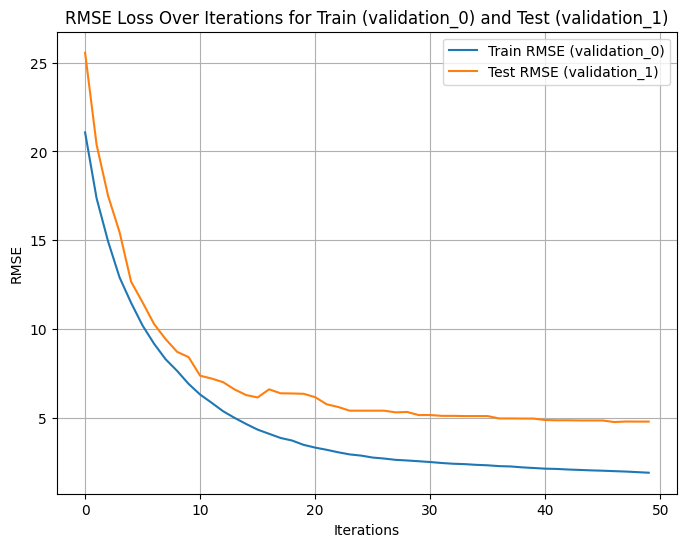

In [7]:
# Retrieve the evals result dictionary from the model
evals_result = model.evals_result()

# Extract train and test RMSE values
train_rmse = evals_result['validation_0']['rmse']
test_rmse = evals_result['validation_1']['rmse']

# Plot the RMSE loss graph for both validation_0 and validation_1
plt.figure(figsize=(8, 6))
plt.plot(train_rmse, label='Train RMSE (validation_0)')
plt.plot(test_rmse, label='Test RMSE (validation_1)')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('RMSE Loss Over Iterations for Train (validation_0) and Test (validation_1)')
plt.legend()
plt.grid(True)
plt.show()

# Model Evaluation

In [8]:

# Model Evaluation
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")

# Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE: {mape} %")


RMSE: 4.773962093114012
MAPE: 1.3130073129747117 %


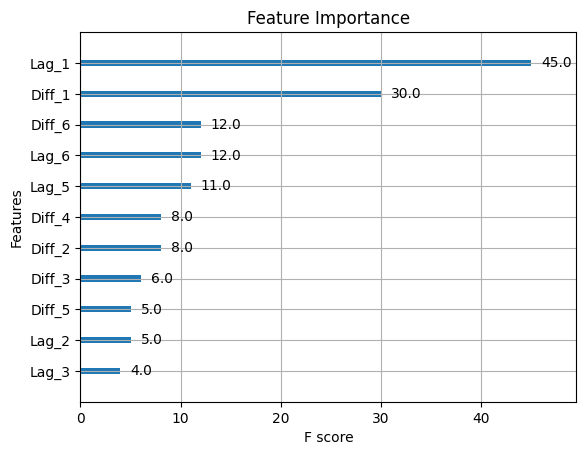

In [9]:
# Feature Importance
xgb.plot_importance(model)
plt.title("Feature Importance")
plt.show()


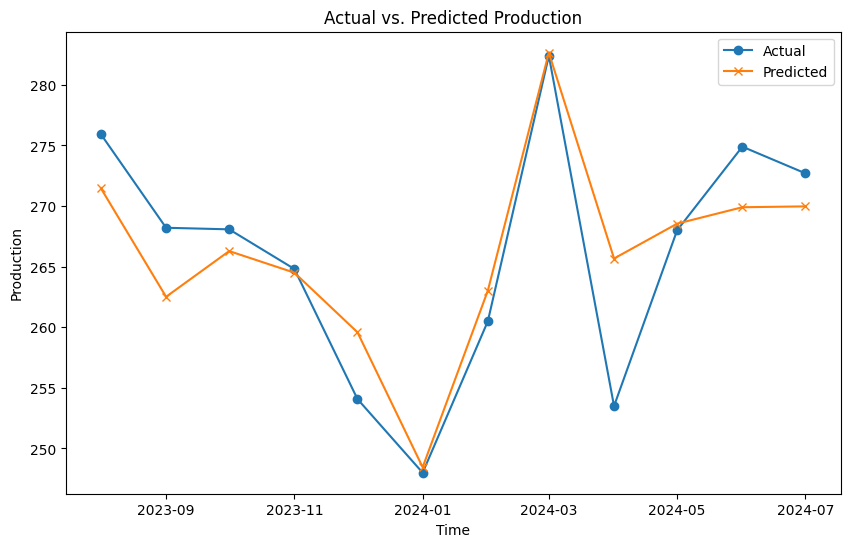

In [10]:
# Plot Actual vs. Predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label="Actual", marker='o')
plt.plot(y_test.index, y_pred, label="Predicted", marker='x')
plt.xlabel("Time")
plt.ylabel("Production")
plt.title("Actual vs. Predicted Production")
plt.legend()
plt.show()

# Future forecasting for 3 months (short term)

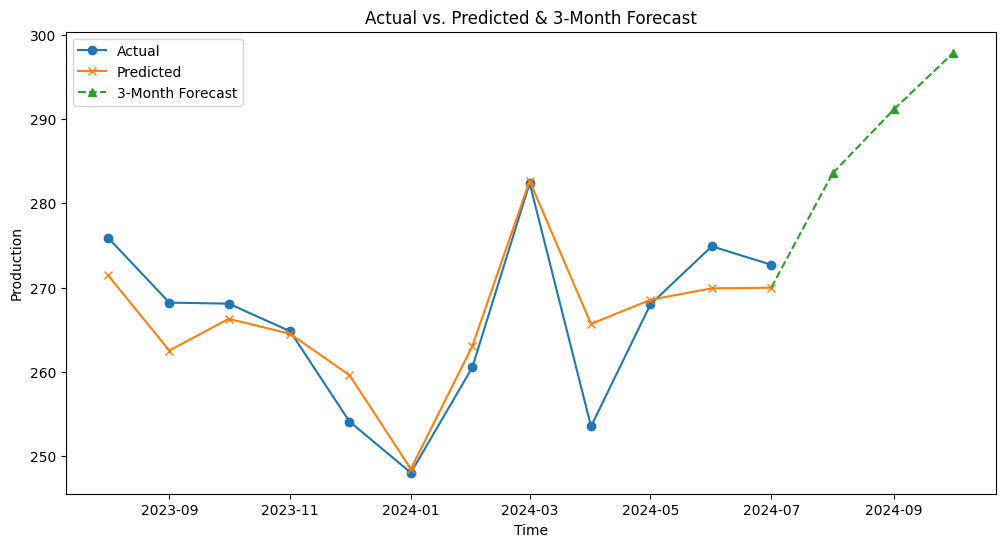

In [11]:
# Future Forecasting (3 months)
future_dates = pd.date_range(start=y_test.index[-1], periods=4, freq='MS')[1:]
future_df = pd.DataFrame(index=future_dates, columns=X_train.columns)

# Create lagged features for future predictions
for i in range(1, 7):  # Create lags from 1 to 6
    future_df[f'Lag_{i}'] = data_featured['Production'].shift(i).tail(len(future_dates) + i).values[i:]

future_df.fillna(method='ffill', inplace=True)
future_predictions = model.predict(future_df)

# Convert predictions back to original scale (if you scaled the data)
future_predictions_original = future_predictions  

# Plot with Future Predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label="Actual", marker='o')
plt.plot(y_test.index, y_pred, label="Predicted", marker='x', color='tab:orange')
plt.plot(future_dates, future_predictions_original, label="3-Month Forecast", 
         linestyle="--", marker='^', color='tab:green') 

# Connect the last predicted point to the first forecast point
plt.plot([y_test.index[-1], future_dates[0]], 
         [y_pred[-1], future_predictions_original[0]], 
         color='tab:green', linestyle='--') 

plt.xlabel("Time")
plt.ylabel("Production")
plt.title("Actual vs. Predicted & 3-Month Forecast")
plt.legend()
plt.show()